### Solving Golomb Ruler Problem using Deep Q-Learning

In [1]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
from keras.models import load_model
import time
import pandas as pd
import h5py
import tensorflow as tf

Using TensorFlow backend.


In [2]:
EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 0.9  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def input_model(self):
        return Dense
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='tanh'))
        model.add(Dense(64, activation='relu', name="middle1"))
        model.add(Dense(128, activation='relu', name="middle2"))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        #explore
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) , 1
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) , 0  # returns action
        

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        # self.model.load_weights(name, by_name=True)
        hf = h5py.File(name, "r")
        w1 = [tf.constant(hf['/middle1/middle1/kernel:0']),tf.constant(hf['/middle1/middle1/bias:0'])]
        w2 = [tf.constant(hf['/middle2/middle2/kernel:0']),tf.constant(hf['/middle2/middle2/bias:0'])]
        self.model.layers[1].set_weights(w1)
        self.model.layers[2].set_weights(w2)

    def save(self, name):
        self.model.save_weights(name)
    
    def reset_state(state,n):
        state = [-1 for i in range(n)]
        return np.array(state)
    
    def calc_reward(self,state):
        l = state.tolist()
        if(-1 in l):
            l = l[:l.index(-1)]
        
        distances = []
        violation_score = 0
        
        for i in range(len(l)-1):
            for j in range(i+1,len(l)):
                distances.append(abs(l[i] - l[j]))
        
        for d in set(distances):
            violation_score += distances.count(d) - 1
        
        return -1 * violation_score
        
    
    def step(self,state,action,n):
        l = state.tolist()[0]
        if(-1 in l):
            l[l.index(-1)] = action
        
        reward = self.calc_reward(np.array(l))
        done = False
        if reward==0 and l.count(-1)==0:
            done = True
        elif(l.count(-1)==0 and reward!=0):
            l = [-1 for i in range(n)]
        next_state = np.array(l)
        
        return next_state,reward,done

        


if __name__ == "__main__":
    # Solve for Golomb ruler of length n
    n = 4
    state_size = n
    # Choose action_size based on optimal length for a given order of ruler. (Greater the number more is the exploration etc.)
    action_size = 10
    agent = DQNAgent(state_size, action_size)
#     agent.load("saved/ruler5.h5")
    done = False
    batch_size = 32
    solutions = []
    converging_iters = []
    start_time = time.time()
    
    rows = []
    
    for episode in range(EPISODES):
        state = [-1 for i in range(n)]
        print("Episode ",episode+1, end= " ")
        i =0
        print("Eplison: ", agent.epsilon)
        start_epsilon = agent.epsilon
        randomActionCount = 0
        while(1):
            
            state = np.array(state)
            state = np.reshape(state, [1, state_size])

            action, isRandom = agent.act(state)
            randomActionCount += isRandom
            next_state, reward, done = agent.step(state,action,n )
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
            if(reward==0 and -1 not in state.tolist()[0]):
                print("Iterations to converge on episode ",episode+1," = ",i+1)
                print("Number of random actions taken: ", randomActionCount)
                soln = sorted(state.tolist()[0])
                soln = ', '.join([str(i) for i in soln])
                print(soln)
                solutions.append(soln)
                converging_iters.append(i+1)
                
                rows.append((n, episode+1, i+1, start_epsilon, agent.epsilon, randomActionCount, batch_size, soln))
                break
            else:
                i = i+1
    end_time = time.time()
    print("Training Time: ", end_time-start_time)

# agent.save("ruler"+str(n)+".h5")

Episode  1 Eplison:  0.9
Iterations to converge on episode  1  =  68
Number of random actions taken:  56
2, 4, 7, 8
Episode  2 Eplison:  0.7514038505868538
Iterations to converge on episode  2  =  88
Number of random actions taken:  58
0, 5, 7, 8
Episode  3 Eplison:  0.4833976356651723
Iterations to converge on episode  3  =  36
Number of random actions taken:  17
1, 2, 4, 8
Episode  4 Eplison:  0.4035853831148793
Iterations to converge on episode  4  =  16
Number of random actions taken:  9
0, 1, 6, 8
Episode  5 Eplison:  0.3724815112577882
Iterations to converge on episode  5  =  8
Number of random actions taken:  2
1, 3, 4, 8
Episode  6 Eplison:  0.35784039672582285
Iterations to converge on episode  6  =  8
Number of random actions taken:  4
1, 2, 4, 8
Episode  7 Eplison:  0.3437747798447725
Iterations to converge on episode  7  =  16
Number of random actions taken:  4
2, 3, 6, 8
Episode  8 Eplison:  0.3172804439561315
Iterations to converge on episode  8  =  4
Number of random act

Iterations to converge on episode  63  =  12
Number of random actions taken:  1
0, 1, 4, 9
Episode  64 Eplison:  0.04990684317543711
Iterations to converge on episode  64  =  4
Number of random actions taken:  0
0, 1, 3, 9
Episode  65 Eplison:  0.04990684317543711
Iterations to converge on episode  65  =  16
Number of random actions taken:  2
0, 1, 4, 9
Episode  66 Eplison:  0.04990684317543711
Iterations to converge on episode  66  =  4
Number of random actions taken:  0
0, 1, 4, 9
Episode  67 Eplison:  0.04990684317543711
Iterations to converge on episode  67  =  4
Number of random actions taken:  2
0, 1, 3, 8
Episode  68 Eplison:  0.04990684317543711
Iterations to converge on episode  68  =  8
Number of random actions taken:  1
0, 1, 4, 9
Episode  69 Eplison:  0.04990684317543711
Iterations to converge on episode  69  =  4
Number of random actions taken:  0
0, 1, 3, 8
Episode  70 Eplison:  0.04990684317543711
Iterations to converge on episode  70  =  8
Number of random actions taken

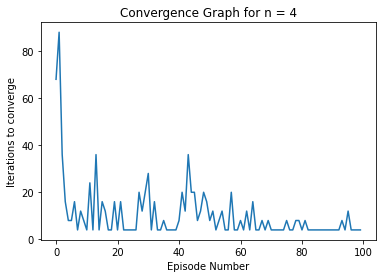

In [3]:
import matplotlib.pyplot as plt

plt.title("Convergence Graph for n = "+str(n))
plt.plot([i for i in range(len(converging_iters))],converging_iters)
plt.xlabel("Episode Number")
plt.ylabel("Iterations to converge")
plt.show()

In [4]:
len(set(solutions))

26

In [5]:
# Unique solutions obtained by DQN
set([i for i in solutions])

{'0, 1, 3, 8',
 '0, 1, 3, 9',
 '0, 1, 4, 6',
 '0, 1, 4, 9',
 '0, 1, 5, 7',
 '0, 1, 5, 8',
 '0, 1, 6, 8',
 '0, 1, 7, 9',
 '0, 2, 3, 8',
 '0, 2, 7, 8',
 '0, 2, 8, 9',
 '0, 3, 4, 9',
 '0, 5, 7, 8',
 '0, 6, 7, 9',
 '1, 2, 4, 8',
 '1, 2, 6, 8',
 '1, 2, 6, 9',
 '1, 3, 4, 8',
 '1, 3, 6, 7',
 '1, 3, 7, 8',
 '1, 4, 8, 9',
 '1, 5, 7, 8',
 '1, 6, 8, 9',
 '2, 3, 6, 8',
 '2, 4, 7, 8',
 '2, 6, 7, 9'}

In [6]:
optimal_solns = []
for i in set(solutions):
    k = int(i.split(', ')[-1])
    # replace 6 by the optimal length for the given order
    if(k==6):
        optimal_solns.append(i)
        
optimal_solns

['0, 1, 4, 6']